In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:

def display_images(images):
    _, axes = plt.subplots(2, 2, figsize=(6, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

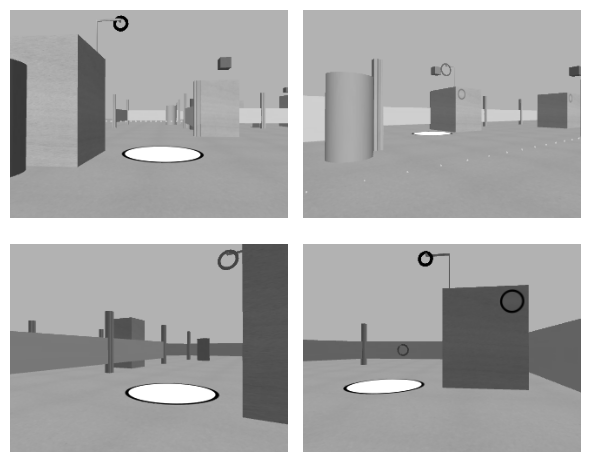

In [5]:
# path = "/home/thelegend442/faxic/RINS-kappa/workspace/src/dis_tutorial5/images/"
path = "workspace/src/dis_tutorial5/images/"
img1 = cv2.imread(path + "gray_screen1.png")
img2 = cv2.imread(path + "gray_screen2.png")
img3 = cv2.imread(path + "gray_screen3.png")
img4 = cv2.imread(path + "gray_screen4.png")

images = [img1, img2, img3, img4]
display_images(images)

Number of ellipses detected: 7


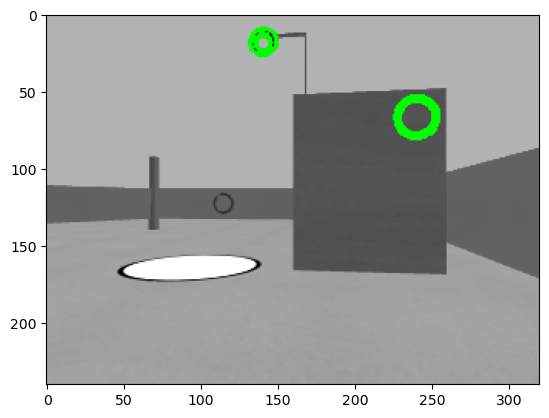

In [6]:
def draw_ellipses2(img, ellipses):
    image = img.copy()
    for ellipse in ellipses:
        cv2.ellipse(image, ellipse, (0, 255, 0), 2)
    
    plt.imshow(image)
    # display_images(image)

def ellipse_detection(image, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=50):
    cut_image = image[0:90,0:320]
    image_blured = cv2.GaussianBlur(cut_image, (3, 3), 0)
    
    # edges_images = []
    ellipses = []
        
    edges = cv2.Canny(image_blured, canny_threshold1, canny_threshold2) # Apply Canny edge detection
    # edges_images.append(edges)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    for contour in contours:
        if len(contour) >= 5:  # Fit ellipse requires at least 5 points
            ellipse = cv2.fitEllipse(contour)
            (center, axes, angle) = ellipse
            major_axis = max(axes)
            minor_axis = min(axes)
            if major_axis == 0 or minor_axis == 0:
                continue
            if major_axis/minor_axis > 2:
                continue
            if min_major_axis <= major_axis <= max_major_axis:
                ellipses.append(ellipse)
    
    return ellipses
        
img = images[3]
ellipsis = ellipse_detection(img, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=50)
print(f"Number of ellipses detected: {len(ellipsis)}")
draw_ellipses2(img, ellipsis)

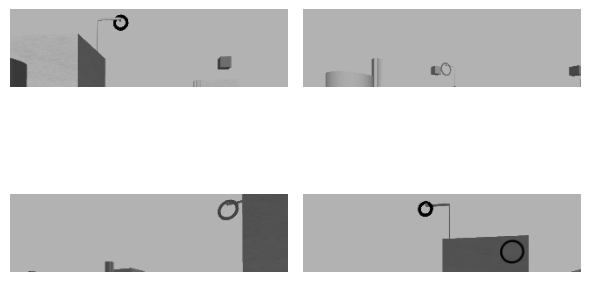

In [7]:
def cut_images(images):
    cut_images = []
    for image in images:
        cut_image = image[0:90,0:320]
        cut_images.append(cut_image)
    return cut_images
cutted_images = cut_images(images)
display_images(cutted_images)

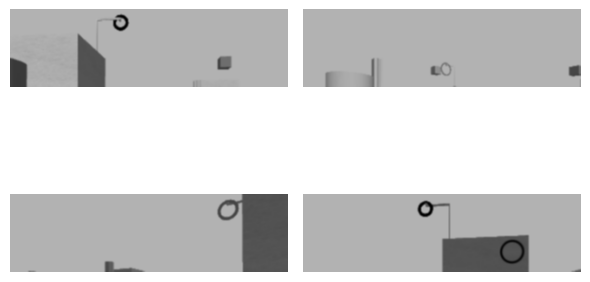

In [8]:

images_blured = []
for image in cutted_images:
    image_blured = cv2.GaussianBlur(image, (3, 3), 0)
    images_blured.append(image_blured)
display_images(images_blured)

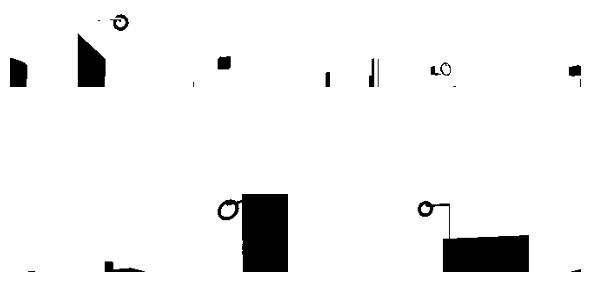

In [9]:
def otsu_thresholding(images, blur_ksize=(7, 7), apply_blur=True):
    thresholded_images = []
    for image in images:
        if apply_blur:
            image = cv2.GaussianBlur(image, blur_ksize, 0)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholded_images.append(thresh)
    return thresholded_images
thresholded_images = otsu_thresholding(cutted_images, blur_ksize=(7, 7), apply_blur=False)
display_images(thresholded_images)

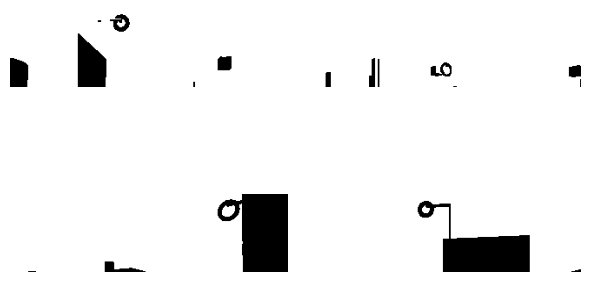

In [10]:
def perform_erosion(images, kernel_size=(3, 3), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    eroded_images = []
    for image in images:
        eroded = cv2.erode(image, kernel, iterations=iterations)
        eroded_images.append(eroded)
    return eroded_images

eroded_images = perform_erosion(thresholded_images, kernel_size=(2, 2), iterations=1)
display_images(eroded_images)

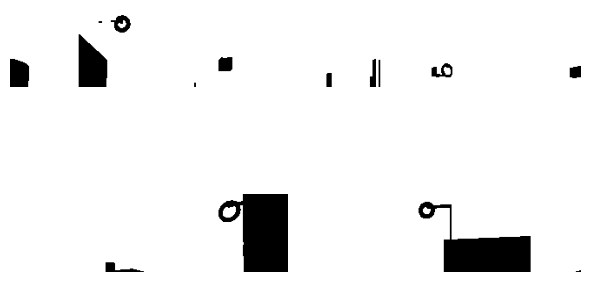

In [11]:
def perform_opening(images, kernel_size=(3, 3), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    opened_images = []
    for image in images:
        opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=iterations)
        opened_images.append(opened)
    return opened_images

opened_images = perform_opening(eroded_images, kernel_size=(2, 2), iterations=1)
display_images(opened_images)

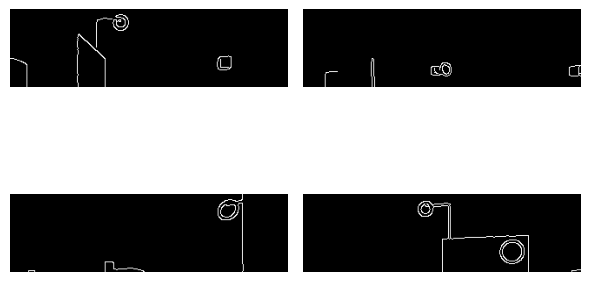

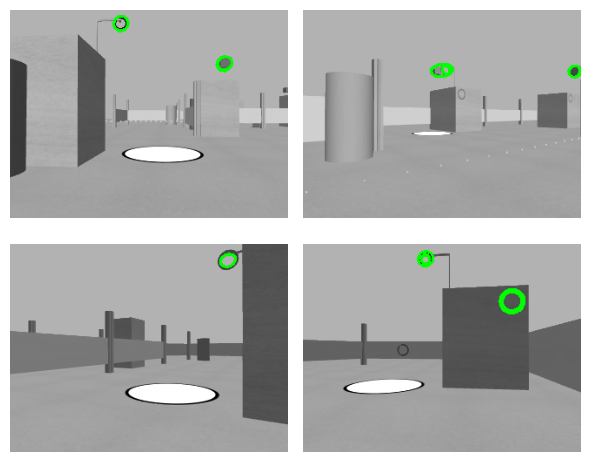

In [12]:
def find_ellipses(images, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=80):
    ellipses_per_img = []
    edges_images = []
    for image in images:
        ellipses = []
        # Apply Canny edge detection
        edges = cv2.Canny(image, canny_threshold1, canny_threshold2)
        edges_images.append(edges)
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        
        for contour in contours:
            if len(contour) >= 5:  # Fit ellipse requires at least 5 points
                ellipse = cv2.fitEllipse(contour)
                (center, axes, angle) = ellipse
                major_axis = max(axes)
                minor_axis = min(axes)
                if major_axis == 0 or minor_axis == 0:
                    continue
                if major_axis/minor_axis > 2:
                    continue
                if min_major_axis <= major_axis <= max_major_axis:
                    ellipses.append(ellipse)
                

        ellipses_per_img.append(ellipses)

    display_images(edges_images)
    return ellipses_per_img

ellipses_per_image = find_ellipses(images_blured, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=50)

def draw_ellipses(images, ellipses_per_image):
    images_copy = [img.copy() for img in images]
    for i, img in enumerate(images_copy):
        for ellipse in ellipses_per_image[i]:
            cv2.ellipse(img, ellipse, (0, 255, 0), 2)

    display_images(images_copy)

draw_ellipses(images, ellipses_per_image)